# 1. Dependencias e setup

In [1]:
pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import os

In [ ]:
# Prevenção de erros OUT OF MEMORY
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Remover imagens incompatíveis

In [4]:
import cv2
import imghdr
data_dir = 'data'
os.listdir(data_dir)

['defect', 'okay']

In [5]:
image_exts = ['jpeg'] # extensões de imagem a serem preservadas

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Carregar dados

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 6633 files belonging to 2 classes.


In [9]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
iterador_dataset = data.as_numpy_iterator() # Transformando dataset em objeto iteravel

In [13]:
batch = iterador_dataset.next() # Obter próximo batch do iterador

In [14]:
batch # Grupo de imagens, 32 imagens por grupo

(array([[[[175.91406 , 175.91406 , 175.91406 ],
          [174.50653 , 174.50653 , 174.50653 ],
          [172.61932 , 172.61932 , 172.61932 ],
          ...,
          [132.39844 , 132.39844 , 132.39844 ],
          [135.48438 , 135.48438 , 135.48438 ],
          [138.16449 , 138.16449 , 138.16449 ]],
 
         [[176.17188 , 176.17188 , 176.17188 ],
          [175.      , 175.      , 175.      ],
          [173.39844 , 173.39844 , 173.39844 ],
          ...,
          [136.42969 , 136.42969 , 136.42969 ],
          [139.51562 , 139.51562 , 139.51562 ],
          [143.03125 , 143.03125 , 143.03125 ]],
 
         [[176.91406 , 176.91406 , 176.91406 ],
          [175.74219 , 175.74219 , 175.74219 ],
          [174.32526 , 174.32526 , 174.32526 ],
          ...,
          [142.4737  , 142.4737  , 142.4737  ],
          [145.05609 , 145.05609 , 145.05609 ],
          [148.06818 , 148.06818 , 148.06818 ]],
 
         ...,
 
         [[155.91406 , 155.91406 , 155.91406 ],
          [155.   

In [15]:
batch[0].shape # Tamanho do batch, dimensões das imagens e seus canais de cores

(32, 256, 256, 3)

In [16]:
batch[1] # Resultados fornecidos das imagens. 0 = Defeito, 1 = Perfeito

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1])

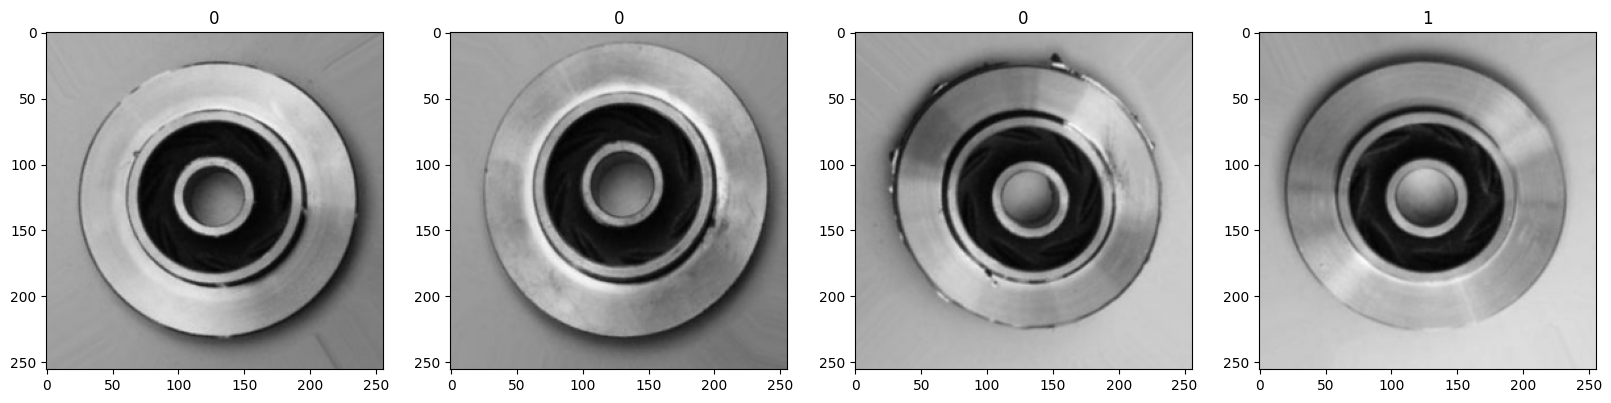

In [17]:
figura, eixo = plt.subplots(ncols=4, figsize=(20,20)) # Criando uma figura e um conjunto de eixos
for indice, img in enumerate(batch[0][:4]): # Iterando sobre 4 imagens no lote
    eixo[indice].imshow(img.astype(int)) # Mostrando a imagem no eixo atual
    eixo[indice].title.set_text(batch[1][indice]) # Definindo o texto do título do eixo com o rótulo correspondente


# 4. Processando imagens

In [19]:
data = data.map(lambda x,y: (x/255, y)) # Normalizando os valores dos pixels para numeros entre entre 0 e 1

In [20]:
iterador_normalizados = data.as_numpy_iterator() # Conversão de dataset normalizado para iterável 

In [22]:
batch = iterador_normalizados.next() # Obter próximo batch do iterável do dataset normalizado

In [23]:
batch # Mostrando imagens com valores de canais de cores normalizados.

(array([[[[0.64705884, 0.64705884, 0.64705884],
          [0.64705884, 0.64705884, 0.64705884],
          [0.64705884, 0.64705884, 0.64705884],
          ...,
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294]],
 
         [[0.64705884, 0.64705884, 0.64705884],
          [0.64705884, 0.64705884, 0.64705884],
          [0.64705884, 0.64705884, 0.64705884],
          ...,
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294]],
 
         [[0.64705884, 0.64705884, 0.64705884],
          [0.64705884, 0.64705884, 0.64705884],
          [0.64705884, 0.64705884, 0.64705884],
          ...,
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294]],
 
         ...,
 
         [[0.66652185, 0.66652185, 0.66652185],
          [0.64561

# 5. Separar dados em grupo de treino, validação e teste

In [ ]:
len(data)

208

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
test_size

20

In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Modelo de Deep Learning

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.python.keras.activations import sigmoid

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))  # extrair características iniciais da imagem
model.add(MaxPooling2D()) # reduzir a dimensionalidade e preservar características mais importantes
model.add(Conv2D(32, (3,3), 1, activation='relu')) #  capturar características mais complexas
model.add(MaxPooling2D()) # continuar reduzindo a dimensionalidade
model.add(Conv2D(16, (3,3), 1, activation='relu'))#  refinamento final das características
model.add(MaxPooling2D())   # redução final da dimensionalidade
model.add(Flatten()) # Transformar a saída da camada convolucional em um vetor unidimensional
model.add(Dense(256, activation='relu')) # Camada densa (totalmente conectada) para aprendizado de padrões complexos
model.add(Dense(1, activation='sigmoid')) # Camada densa com ativação sigmoidal para classificação binária

In [13]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

# 7. Treinando

In [15]:
logdir='logs'

In [16]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
145/145 [==============================] - 314s 2s/step - loss: 0.6218 - accuracy: 0.6905 - val_loss: 0.4581 - val_accuracy: 0.8110
Epoch 2/20
145/145 [==============================] - 296s 2s/step - loss: 0.3628 - accuracy: 0.8431 - val_loss: 0.2311 - val_accuracy: 0.9276
Epoch 3/20
145/145 [==============================] - 292s 2s/step - loss: 0.1928 - accuracy: 0.9330 - val_loss: 0.1369 - val_accuracy: 0.9611
Epoch 4/20
 54/145 [==========>...................] - ETA: 2:33 - loss: 0.1652 - accuracy: 0.9387

# 8. Mostrar resultados do treinamento

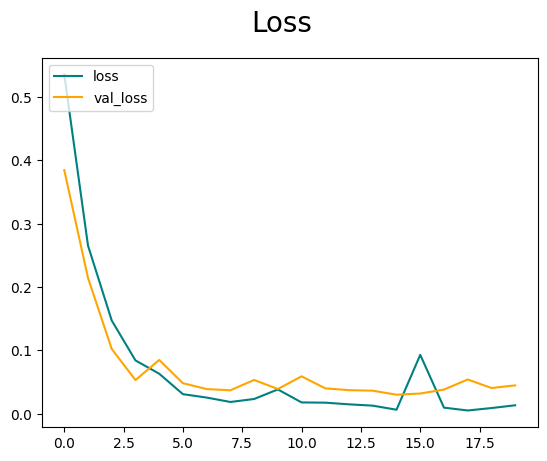

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

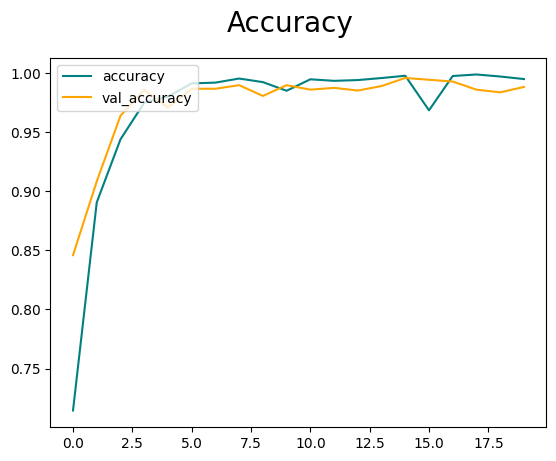

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Avaliar

In [ ]:
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
len(test)

20

In [ ]:
for batch in test.as_numpy_iterator():
    item, label = batch
    resultado = loaded_model.predict(item)
    pre.update_state(label, resultado)
    re.update_state(label, resultado)
    acc.update_state(label, resultado)

1/1 [==============================] - 0s 499ms/step


In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.97875, shape=(), dtype=float32) tf.Tensor(0.97146404, shape=(), dtype=float32) tf.Tensor(0.9791667, shape=(), dtype=float32)


# 10. Testar modelo

In [3]:
import cv2

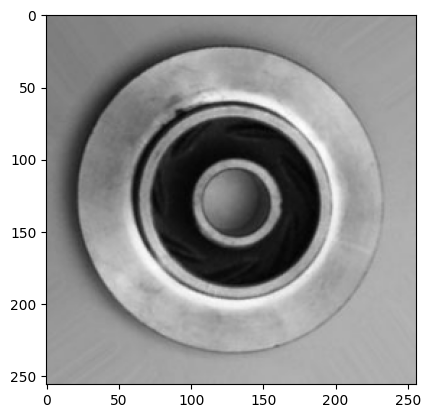

In [8]:
img = cv2.imread('test/defect/cast_def_0_143.jpeg')
resize = tf.image.resize(img, (256,256)) #trocar tamanho para o tamanho que o modelo espera
plt.imshow(resize.numpy().astype(int))
plt.show()

In [9]:
array_predicao = loaded_model.predict(np.expand_dims(resize/255, 0))

In [10]:
array_predicao

array([[6.712774e-12]], dtype=float32)

In [11]:
lista_predicao = array_predicao.astype(float).tolist()
valor_predicao = lista_predicao[0][0]
valor_predicao_texto = format(valor_predicao, ',.8f')
print(valor_predicao)
print(valor_predicao_texto)

6.7127739998562586e-12
0.00000000


In [12]:
if valor_predicao > 0.5:
    print(f'Peça sem defeitos')
else:
    print(f'Peça com defeitos')

Peça com defeitos


# 11. Salvar e carregar modelo

In [1]:
from tensorflow.python.keras.models import load_model

In [ ]:
model.save('pecasdefeituosas.keras')

In [2]:
loaded_model = load_model("models/pecasdefeituosas.keras")